## Perform analysis on CheXNet train, val, test split and remove bad sample from the data

In [1]:
import pandas as pd
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import math
import numpy as np

## 1. Check CheXNet train, val, test split

In [3]:
def get_id(row):
    return row.split('_')[0].lstrip('0')

In [4]:
strong_df = pd.read_csv('BBox_List_2017.csv')
strong_patient_ids = set(strong_df['Image Index'].apply(get_id).values)
print('Strong patient', len(strong_patient_ids))

Strong patient 726


In [5]:
chexnet_train_df = pd.read_csv('chexnet_train_list.csv', header=None, delimiter=' ')
chexnet_val_df = pd.read_csv('chexnet_val_list.csv', header=None, delimiter=' ')
chexnet_test_df = pd.read_csv('chexnet_test_list.csv', header=None, delimiter=' ')
train_patients_ids = set(chexnet_train_df.iloc[:, 0].apply(get_id).values)
val_patients_ids = set(chexnet_val_df.iloc[:, 0].apply(get_id).values)
test_patients_ids = set(chexnet_test_df.iloc[:, 0].apply(get_id).values)

In [6]:
print('Train size', len(chexnet_train_df), len(train_patients_ids))
print('Val size', len(chexnet_val_df), len(val_patients_ids))
print('Train size', len(chexnet_test_df), len(test_patients_ids))

Train size 78468 21528
Val size 11219 3090
Train size 22433 6187


### Check strong label in train, test, val

In [8]:
# Check if strong label in train 
print('Train patient', len(train_patients_ids))
strong_train_intersect_ids = train_patients_ids.intersection(strong_patient_ids)
print('Interect with strong label', len(strong_train_intersect_ids))

Train patient 21528
Interect with strong label 511


In [9]:
# check if strong label in val
print('Val patient', len(val_patients_ids))
strong_val_intersect_ids = val_patients_ids.intersection(strong_patient_ids)
print('Interect with strong label', len(strong_val_intersect_ids))

Val patient 3090
Interect with strong label 67


In [10]:
# check if strong label in test
print('test patient', len(test_patients_ids))
strong_test_intersect_ids = test_patients_ids.intersection(strong_patient_ids)
print('Interect with strong label', len(strong_test_intersect_ids))

test patient 6187
Interect with strong label 148


In [9]:
# The strong label is spread accross train, val and test set
len(strong_train_intersect_ids) + len(strong_test_intersect_ids) + len(strong_val_intersect_ids) == len(strong_patient_ids)

True

### Check overlap between train, val, test

In [11]:
# check overlap between patient id in train and val
intersect_ids = train_patients_ids.intersection(val_patients_ids)
print('Overlap train val', len(intersect_ids))

Overlap train val 0


In [12]:
# check overlap between patient id in train and test
intersect_ids = train_patients_ids.intersection(test_patients_ids)
print('Overlap train test', len(intersect_ids))

Overlap train test 0


In [13]:
# check overlap between patient id in val and test
intersect_ids = val_patients_ids.intersection(test_patients_ids)
print('Overlap val test', len(intersect_ids))

Overlap val test 0


### Is chexnet split is originated from nih?

In [14]:
nih_test_df = pd.read_csv('nih_test_list.csv', header=None)
nih_test_patient_ids = set(nih_test_df.iloc[:, 0].apply(get_id).values)
nih_chexnet_test_intersect = nih_test_patient_ids.intersection(test_patients_ids)
print('NIH test', len(nih_test_patient_ids))
print('CheXnet test', len(test_patients_ids))
print('Overlap', len(nih_chexnet_test_intersect))

NIH test 2797
CheXnet test 6187
Overlap 590


The answer is no

### Get strong label in test set and extract to csv to show result as prediction and CAM

In [21]:
# strong_test_df = 
chexnet_test_df.head()
chexnet_test_df['patient_id'] = chexnet_test_df.iloc[:, 0].apply(get_id).values
chexnet_test_df.head()
idx = chexnet_test_df.patient_id.apply(lambda id_: id_ in strong_test_intersect_ids)
strong_test_df = chexnet_test_df[idx]
strong_test_df = strong_test_df.drop('patient_id', axis=1)
strong_test_df.to_csv('chexnet_strong_test.csv', header=None, sep=' ')

0  1  2  3  4  5  6  7  8  9  10  11  12  13  14 patient_id
0  00011997_000.png  0  0  0  0  0  0  0  0  0   0   0   0   0   0      11997
1  00011997_001.png  0  0  0  0  0  0  0  0  0   0   0   0   0   0      11997
2  00011997_002.png  0  0  0  0  0  0  0  0  0   0   0   0   0   0      11997
3  00011997_003.png  0  0  1  0  0  0  0  0  0   0   0   0   0   0      11997
4  00011997_004.png  0  1  1  1  0  0  0  0  0   0   0   0   0   0      11997

## 2. Visualize bad data and remove it from train, val, test split

In [16]:
base_dir = '/home/dattran/data/xray/'
def plot_batch(image_names, title, n=24):
    cols = 6
    image_names = shuffle(image_names)
    n = min(len(image_names), n)
    rows = math.floor(n/cols)
    plt.figure(figsize=(24, 4*rows))
    plt.suptitle(title, size=20)
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        image_file = base_dir + image_names[i]
        imshow(image_file)

def imshow(file):
    plt.imshow(Image.open(file).convert('RGB'))
    plt.xticks([])
    plt.yticks([])

#### Rotated image

18

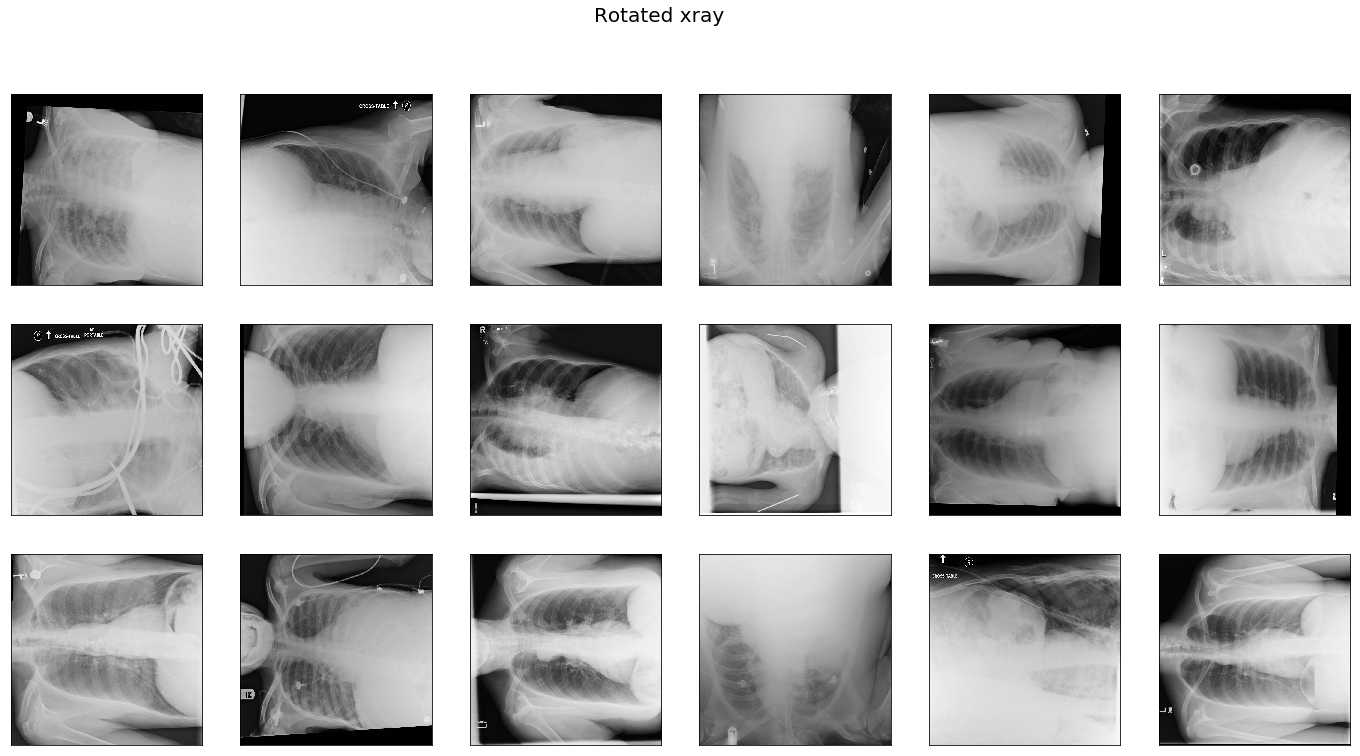

In [42]:
azure_rotated = pd.read_csv('blacklist_rotated_images.csv', header=None)
azure_rotated = azure_rotated.values.squeeze()
plot_batch(azure_rotated, 'Rotated xray')
azure_rotated.size

#### Side Xray with no frontal view

56

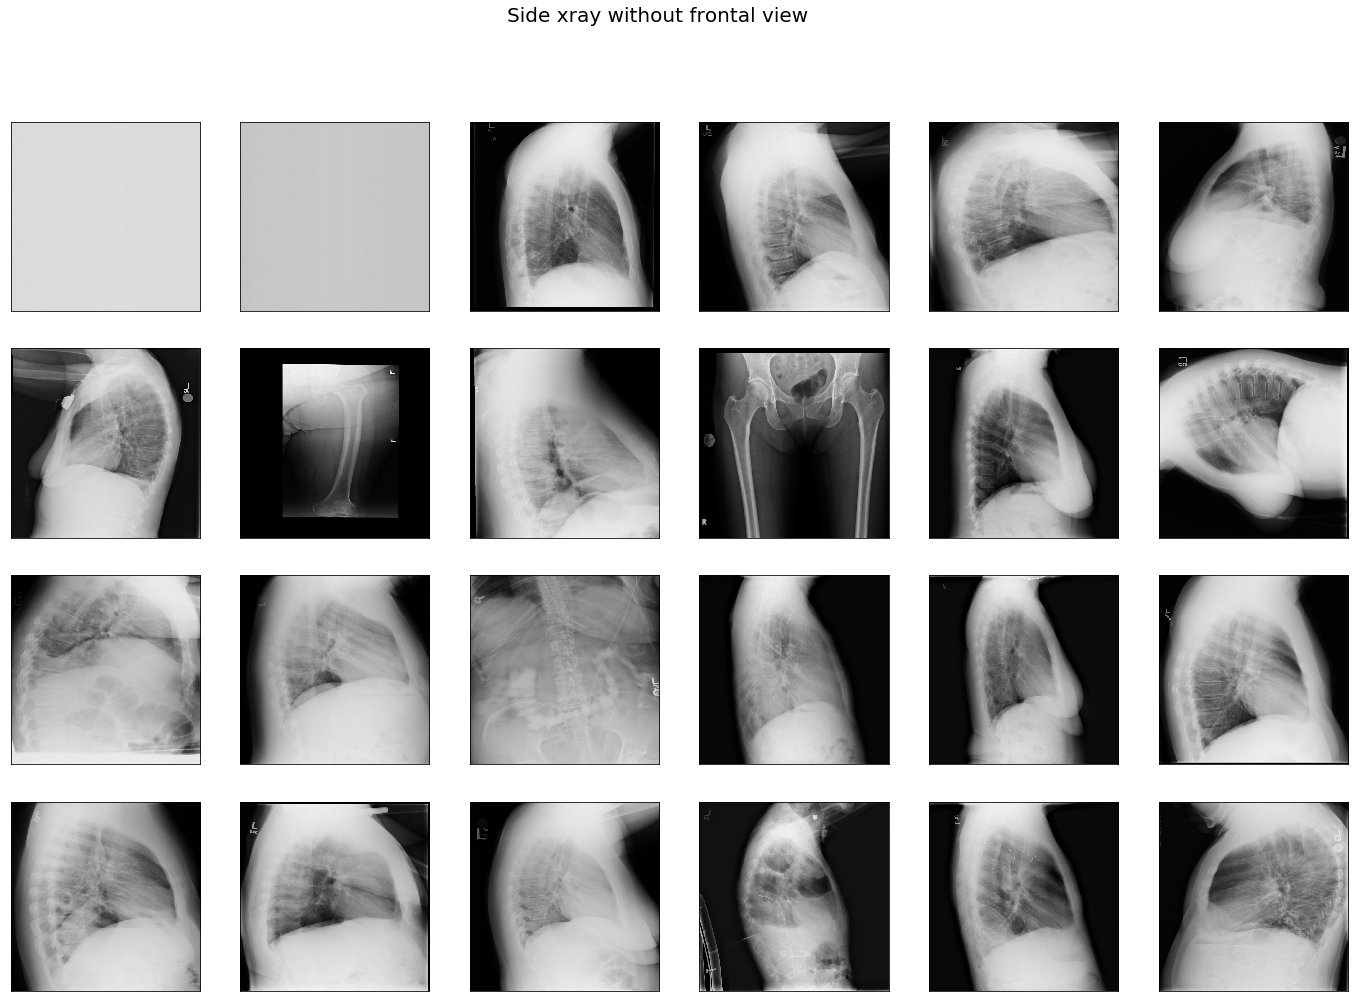

In [43]:
azure_nonPA = pd.read_csv('blacklist_non_PA_AP_view.csv', header=None)
azure_nonPA = azure_nonPA.values.squeeze()
plot_batch(azure_nonPA, 'Side xray without frontal view')
azure_nonPA.size

#### Low quality

1094

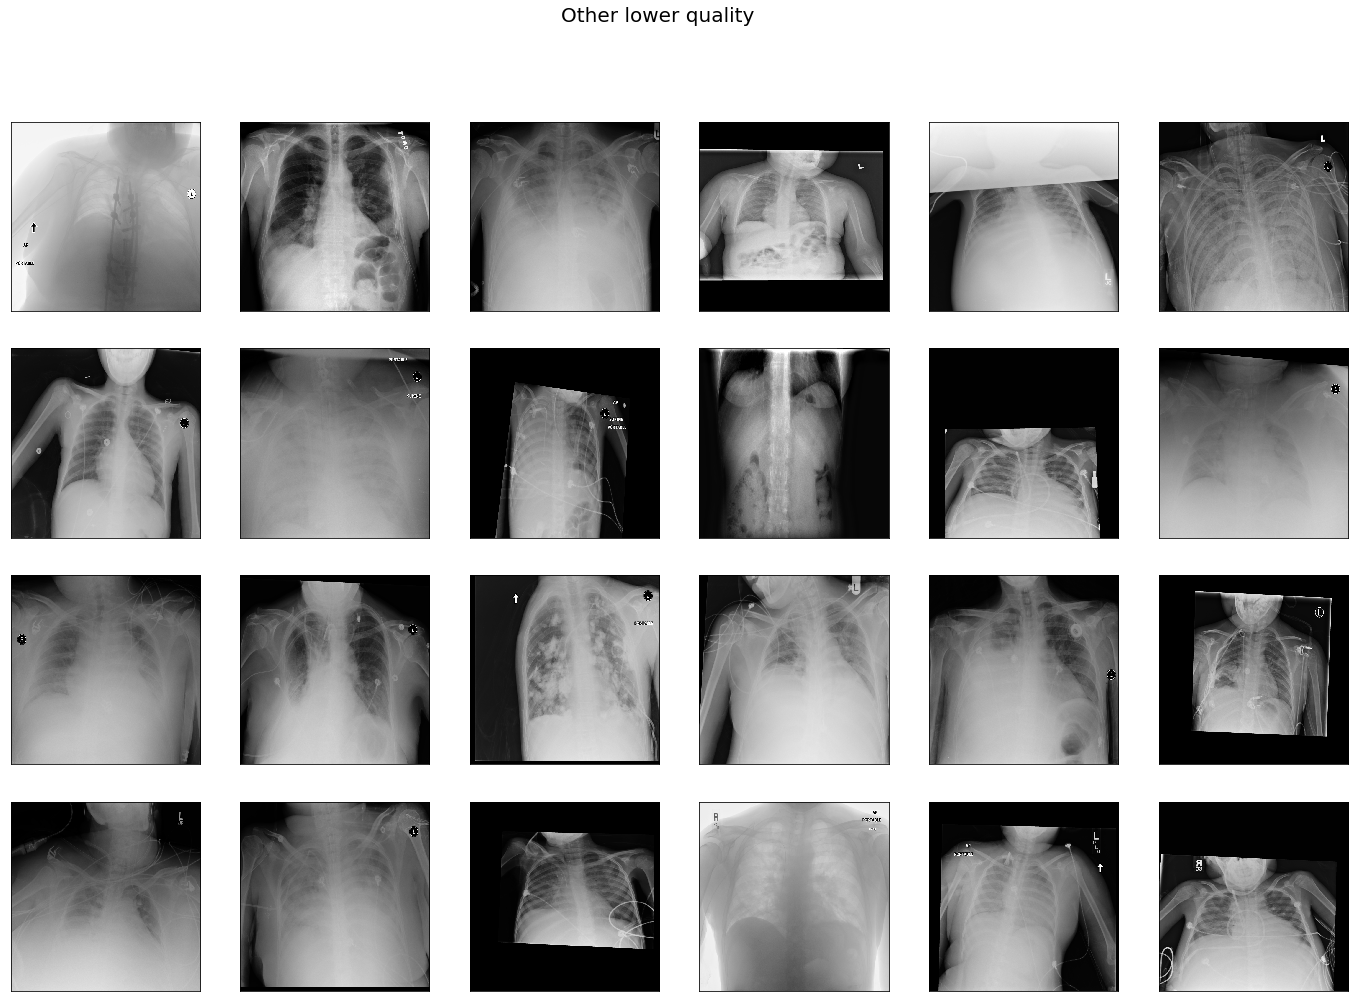

In [44]:
azure_low_quality = pd.read_csv('blacklist_other_images_with_lower_quality.csv', header=None)
azure_low_quality = azure_low_quality.values.squeeze()
plot_batch(azure_low_quality, 'Other lower quality')
azure_low_quality.size

#### Age < 10

1425

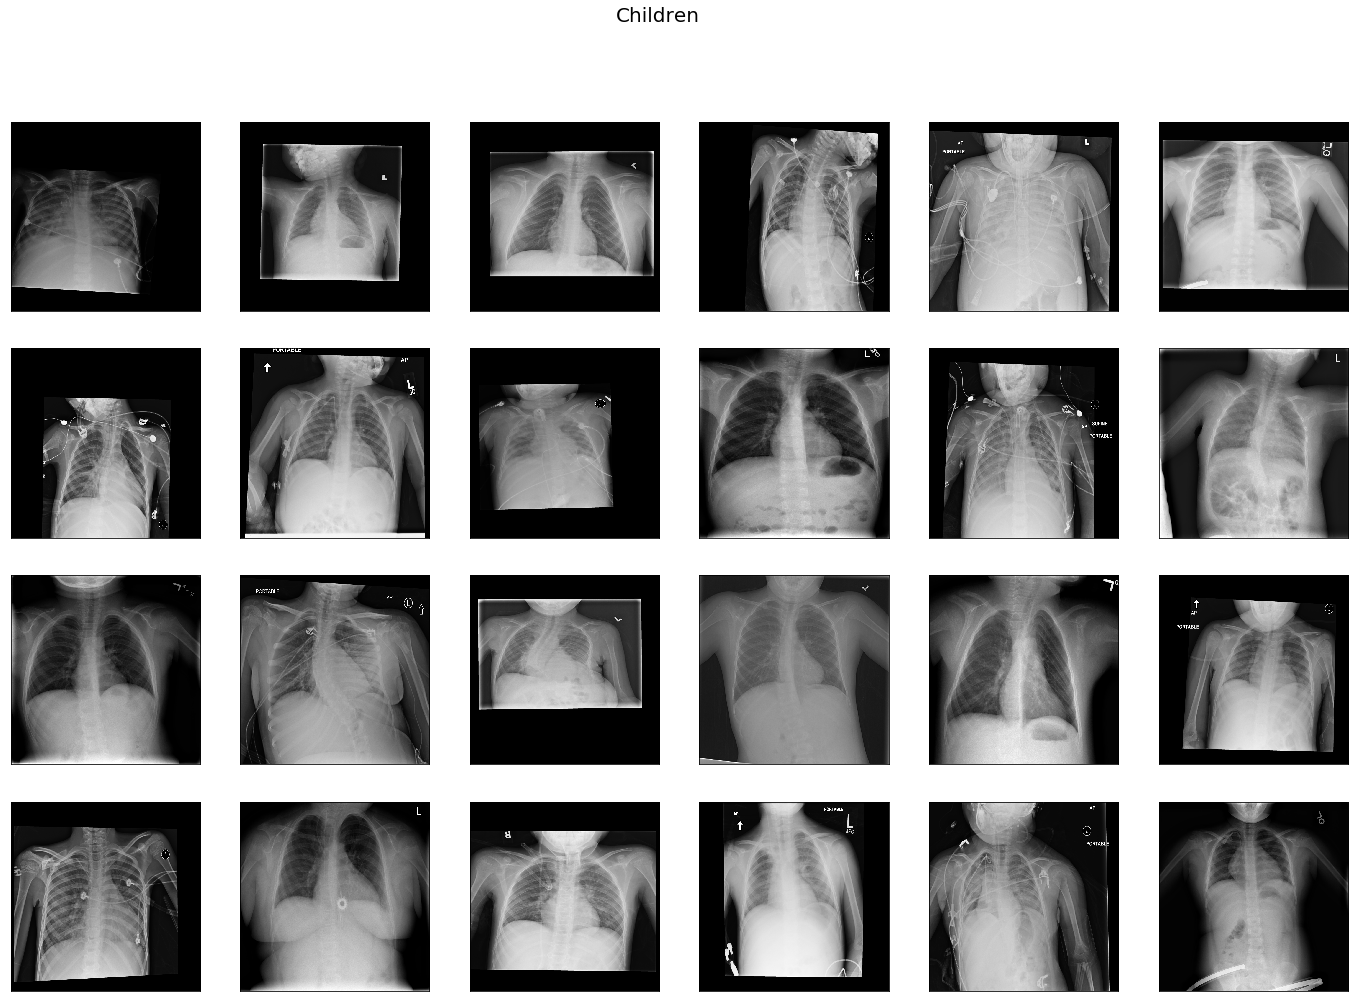

In [45]:
df = pd.read_csv('Data_Entry_Clean.csv')
age_below_10 = df[df.Age < 10]['Image Index'].values
plot_batch(age_below_10, 'Children')
age_below_10.size

In [46]:
luke_df = pd.read_csv('cxr14_bad_labels.csv')
luke_df.head()

Unnamed: 0             Index  Inverted  Not frontal  Rotated
0           0  00000583_024.png       1.0          0.0      0.0
1           1  00002180_000.png       1.0          0.0      0.0
2           2  00002300_026.png       1.0          0.0      0.0
3           3  00002371_015.png       1.0          0.0      0.0
4           4  00006209_001.png       1.0          0.0      0.0

62

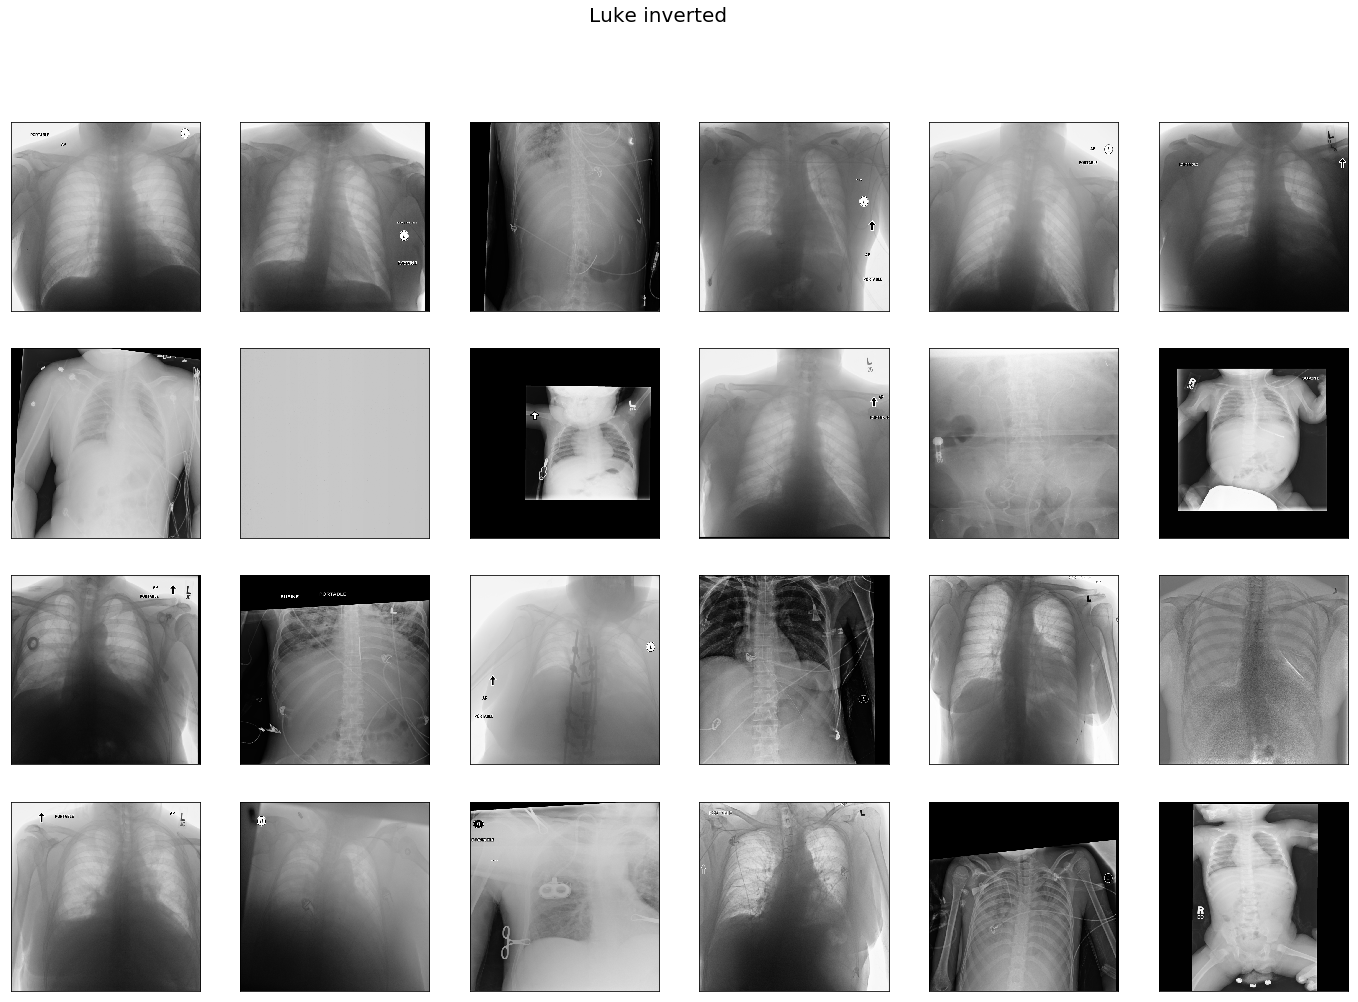

In [47]:
luke_inverted = luke_df[luke_df.Inverted == 1.0]['Index'].values
plot_batch(luke_inverted, 'Luke inverted')
luke_inverted.size

51

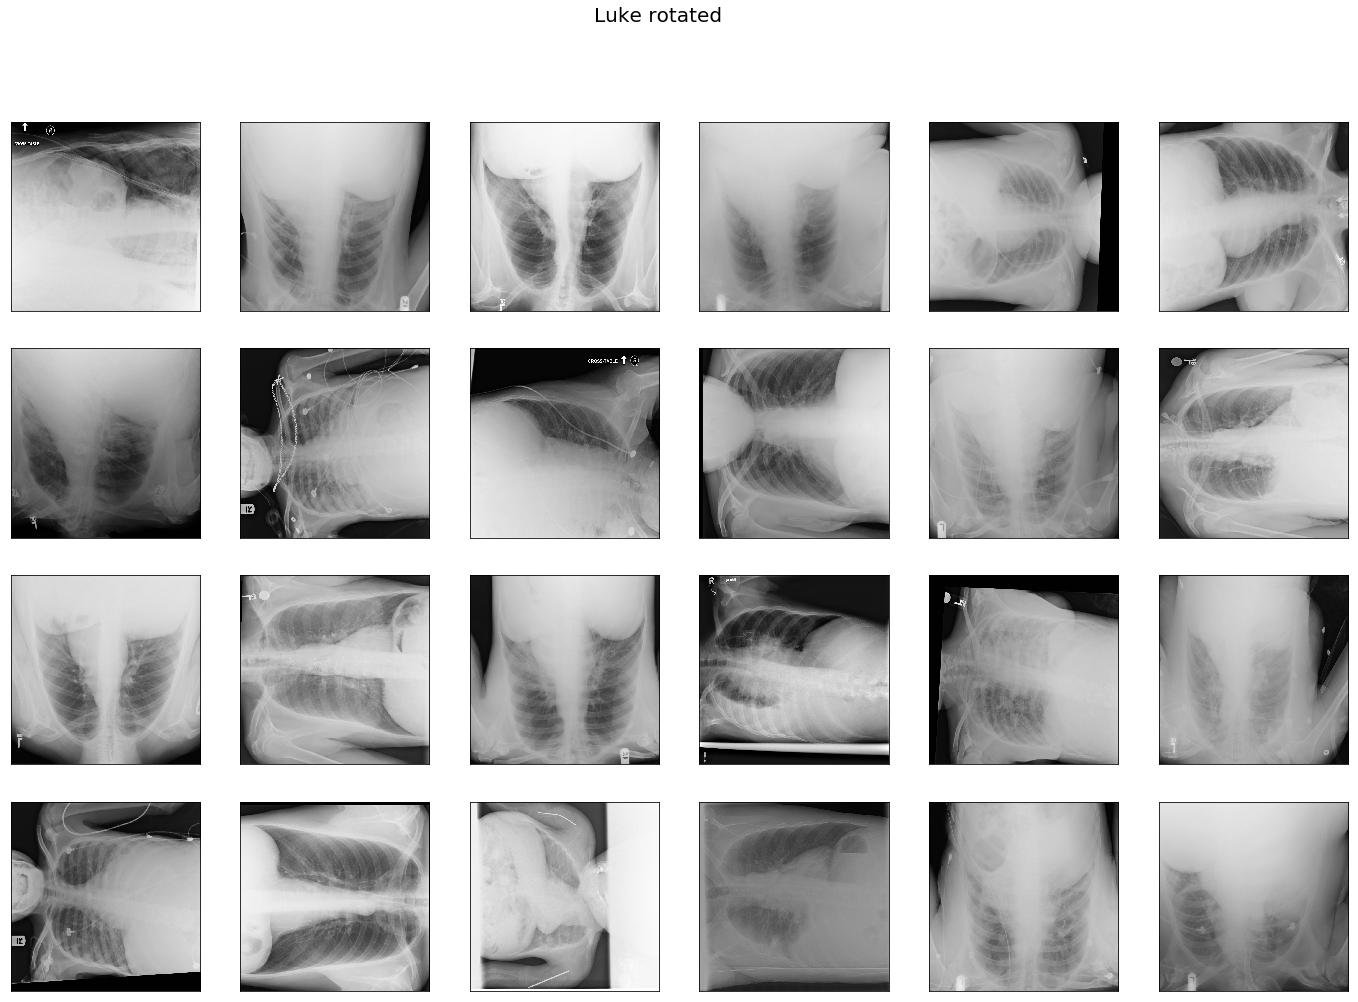

In [48]:
luke_rotated = luke_df[luke_df.Rotated == 1.0]['Index'].values
plot_batch(luke_rotated, 'Luke rotated')
luke_rotated.size

319

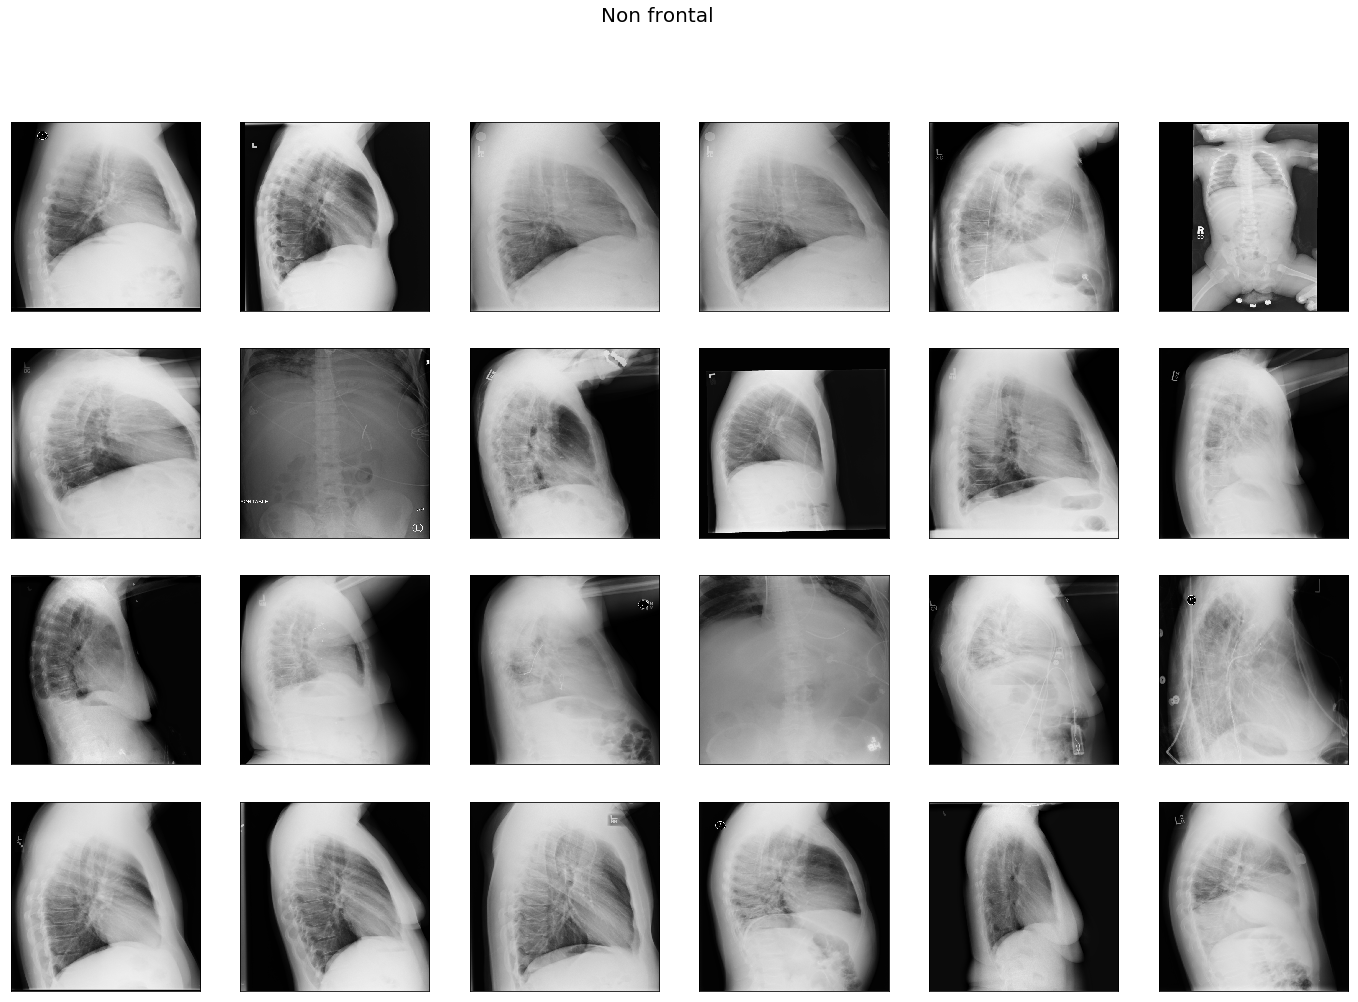

In [49]:
luke_nonPA = luke_df[luke_df['Not frontal'] == 1.0]['Index'].values
plot_batch(luke_nonPA, 'Non frontal')
luke_nonPA.size

In [56]:
image_to_excludes = set(azure_nonPA.tolist() + azure_rotated.tolist() + azure_low_quality.tolist() 
                        + luke_inverted.tolist() + luke_nonPA.tolist() + luke_rotated.tolist()
                        + age_below_10.tolist())
len(image_to_excludes)

2355

In [92]:
def clean_chexnet(in_csv, out_csv):
    df = pd.read_csv(in_csv, header=None, delimiter=' ')
    should_drop = lambda x: x in image_to_excludes
    df['Drop?'] = df.iloc[:, 0].apply(should_drop)
    print('Origin', len(df), 'To drop', len(df[df['Drop?'] == True]))
    df = df[df['Drop?'] == False]
    df = df.drop('Drop?', axis=1)
    print('Remain', len(df) )
    print('_'*20)
    df.to_csv(out_csv, header=None, index=False, sep=' ')

In [93]:
print('Train')
clean_chexnet('chexnet_train_list.csv', 'train_list.csv')
print('Val')
clean_chexnet('chexnet_val_list.csv', 'val_list.csv')
print('Test')
clean_chexnet('chexnet_test_list.csv', 'test_list.csv')

Train
Origin 78468 To drop 1613
Remain 76855
____________________
Val
Origin 11219 To drop 298
Remain 10921
____________________
Test
Origin 22433 To drop 444
Remain 21989
____________________
